## Fisrt step: translate the fitness funcion to our SNN function

In [141]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import pandas as pd
import random
from array import *
import itertools

The Rastrigin function is often used when exploring numerical optimization

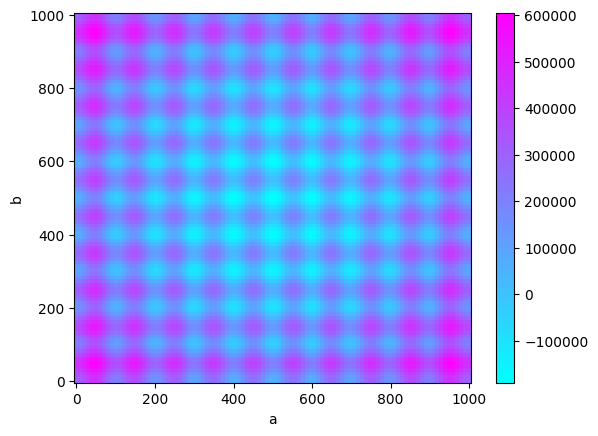

In [142]:
# Fitness function
def f(X,Y):
	Z = ((X-500)**2 - 100000 * np.cos(2 * np.pi * X)) + ((Y-500)**2 - 100000 * np.cos(2 * np.pi * Y)) + 20
	return Z

#plt the function
x = np.linspace(0,1000,100)
y = np.linspace(0,1000,100)
X,Y = np.meshgrid(x,y)
Z = f(X,Y)

plt.pcolormesh(X, Y, Z, cmap = 'cool', shading='auto')
plt.xlabel('a')
plt.ylabel('b')
plt.colorbar()


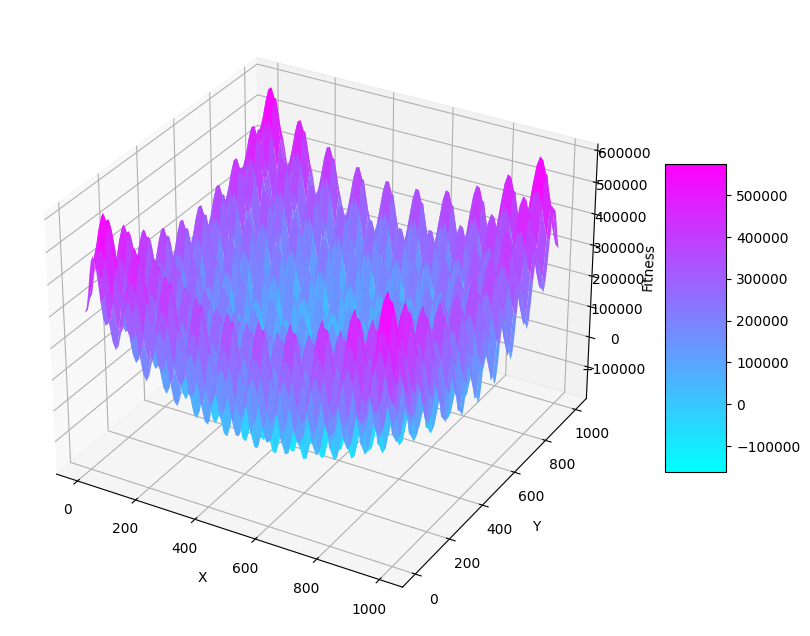

In [143]:
Z = f(X, Y)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='cool', edgecolor='none')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Fitness')

# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

# Show plot
plt.show()

In [144]:
# Initialize parameters
num_parameters = 2
population_size = 6

MAX_population_size = 20 #Not necessary but I don't want to break the machines

num_childs = 4
pc = 0.6  # Probability of crossover
pm = 0.03  # Probability of mutation

random.seed(random.random())

# Fitness function
def fitness(X,Y):
    return f(X,Y)

In [145]:
a, a_MAX, a_MIN = 46, 1, 1000
b, b_MAX, b_MIN = 12, 1, 1000

In [146]:
import os
#delete the values.csv
if os.path.exists('ToyValues.csv'):
    os.remove('ToyValues.csv')

#create the values.csv and write the header
with open('ToyValues.csv', 'w') as file:
    file.write('a,b,fitness\n')

In [147]:
# Mapping functions
def encode_and_scale(real_value, min_value, max_value, num_bits):
    scaled_value = int((real_value - min_value) / (max_value - min_value) * (2**num_bits - 1))
    binary_representation = bin(scaled_value)[2:].zfill(num_bits)
    return binary_representation

def decode_and_rescale(encoded_value, min_value, max_value, num_bits):
    scaled_value = int(encoded_value, 2)
    real_value = min_value + scaled_value / (2**num_bits - 1) * (max_value - min_value)
    return real_value


# Initialize the population
def InitPopulation():
    generations = {}
    for i in range(population_size):
        random_a = random.uniform(a_MIN, a_MAX)
        random_b = random.uniform(b_MIN, b_MAX)


        fit = fitness(random_a, random_b)
        a_bin = encode_and_scale(random_a, a_MIN, a_MAX, 10)
        b_bin = encode_and_scale(random_b, b_MIN, b_MAX, 10)


        dna = a_bin + b_bin
        generations[i] = {"dna": dna, "fitness": fit}
    return generations


def roulette_wheel(generationDictN):
    max_fitness = generationDictN[0]['fitness']
    for f in generationDictN.values():
        if f['fitness'] > max_fitness:
            max_fitness = f['fitness']
            
    total_fitness = sum((max_fitness - individual["fitness"]) for individual in generationDictN.values())
    if total_fitness == 0:
        return generationDictN
    
    selection_probabilities = {key: (max_fitness - individual["fitness"]) / total_fitness for key, individual in generationDictN.items()}
    
    cumulative_probabilities = {}
    cumulative_prob = 0
    for key, prob in selection_probabilities.items():
        cumulative_prob += prob
        cumulative_probabilities[key] = cumulative_prob
    
    new_generation = {}
    for _ in range(len(generationDictN)):
        rand_num = random.random()
        selected_key = next(key for key, prob in cumulative_probabilities.items() if prob >= rand_num)
        new_generation[_] = generationDictN[selected_key]
    
    return new_generation


# Crossover function
def CrossOver(SelectedNumbersDict):
    NewGenFromSelected = {}

    for i in range(0, len(SelectedNumbersDict) - 1, 2):  # Adjusted loop condition
        randnum = random.random()
        cod1 = SelectedNumbersDict[i]["dna"]
        cod2 = SelectedNumbersDict[i + 1]["dna"]


        # Add parents to the new generation if they don't pass the probability
        if randnum > pc:
            NewGenFromSelected[i] = {"dna": cod1}
            NewGenFromSelected[i + 1] = {"dna": cod2}
        else:
            # Add children to the new generation if they pass the probability
            num1 = [cod1[i:i+10] for i in range(0, len(cod1), 10)]
            num2 = [cod2[i:i+10] for i in range(0, len(cod2), 10)]

            a = [1, 2]
            comb = list(itertools.product(a, repeat=num_parameters))
            
            #shuffle randomly the combinations
            random.shuffle(comb)

            sel_comb = random.sample(comb, num_childs)

            child = ["" for _ in range(num_childs)]
            for c in range(num_childs):
                child[c] = ""
                for k in range(num_parameters):
                    if sel_comb[c][k] == 1:
                        child[c] += num2[k]
                    elif sel_comb[c][k] == 2:
                        child[c] += num1[k]
            # Add the children to the new generation
            for c in range(2):
                NewGenFromSelected[len(NewGenFromSelected)] = {"dna": child[c]}

    # never true, but I don't want to risk the machines
    if len(NewGenFromSelected) > MAX_population_size:
        NewGenFromSelected = dict(random.sample(NewGenFromSelected.items(), MAX_population_size))

    return NewGenFromSelected


# Mutation function
def flip_bit(bit):
    return '1' if bit == '0' else '0'

def Mutation(individual, num_bits=10):
    encoded_value = individual["dna"]
    mutated_encoded_value = ''

    nb = 0
    for i, bit in enumerate(encoded_value):
        # Calculate mutation probability based on the position of the bit within the binary string
        nb = nb + 1
        mutation_prob = np.exp(-0.5 * nb) * pm  # Exponential decay function for mutation probability

        # Perform mutation with the scaled probability
        rm = random.random()
        if rm < mutation_prob:
            mutated_bit = flip_bit(bit)
        else:
            mutated_bit = bit

        mutated_encoded_value += mutated_bit

        if nb == num_bits:
            nb = 0

    individual["dna"] = mutated_encoded_value
    return individual

# Decode the fitness and calculate it for each new generation
def DecodeAndCalFitness(SelectedNumbersDict):
    bestfit = float('inf')
    bestXY = ""
    
    for _, individual in SelectedNumbersDict.items():
        num = individual["dna"]
        variables = [num[i:i+10] for i in range(0, len(num), 10)]
        a, b = variables

        map_a = decode_and_rescale(a, a_MIN, a_MAX, 10)
        map_b = decode_and_rescale(b, b_MIN, b_MAX, 10)


        fit = fitness(map_a, map_b)
        individual["fitness"] = fit

        with open('ToyValues.csv', 'a') as f:
            f.write(f'{map_a},{map_b},{fit}\n')

        if fit < bestfit:
            bestfit = fit
            bestXY = num

    return SelectedNumbersDict, bestfit, bestXY

# Genetic Algorithm
def GA():
    t = 0
    maxIteration = 500
    bestfitness = float('inf')  # Initialize to positive infinity
    bestXY = ""
    IterFound = 0
    generationDictN = InitPopulation()
    print("InitPop", generationDictN)

    while t < maxIteration:
        print("Generation: ", t , "----------------------------------------------------------")
        SelectedNumbersDict = roulette_wheel(generationDictN)

        print("Roulette", SelectedNumbersDict)
        SelectedNumbersDict = CrossOver(SelectedNumbersDict)

        print("Crossover", SelectedNumbersDict)


        # Apply mutation to each individual separately
        SelectedNumbersDict = {key: Mutation(individual) for key, individual in SelectedNumbersDict.items()}
        print("Mutation", SelectedNumbersDict)

        generationDictN, bestfit, bestXandY = DecodeAndCalFitness(SelectedNumbersDict)

        if bestfit < bestfitness:
            bestfitness = bestfit
            bestXY = bestXandY
            IterFound = t
            
        t += 1

    return bestfitness, bestXY, IterFound



bestfitness, bestXY, IterFound = GA()
print(bestfitness, bestXY, IterFound)

a, b = bestXY[:10], bestXY[10:20]



map_a = decode_and_rescale(a, a_MIN, a_MAX, 10)
map_b = decode_and_rescale(b, b_MIN, b_MAX, 10)

print("Best Fitness:", bestfitness)    
print("Mapped tau_s:", map_a)
print("Mapped tau_m:", map_b)
print("Iteration Found:", IterFound)

InitPop {0: {'dna': '00000111011110011001', 'fitness': 556367.2635786538}, 1: {'dna': '00010101011101110100', 'fitness': 479347.5710741481}, 2: {'dna': '11010011101100001101', 'fitness': 42915.14150240505}, 3: {'dna': '11101011011010100101', 'fitness': 186885.4316314009}, 4: {'dna': '01000000010101010000', 'fitness': 243022.50768607575}, 5: {'dna': '10010000011011000000', 'fitness': 9617.940489917495}}
Generation:  0 ----------------------------------------------------------
Roulette {0: {'dna': '01000000010101010000', 'fitness': 243022.50768607575}, 1: {'dna': '11010011101100001101', 'fitness': 42915.14150240505}, 2: {'dna': '01000000010101010000', 'fitness': 243022.50768607575}, 3: {'dna': '11101011011010100101', 'fitness': 186885.4316314009}, 4: {'dna': '00010101011101110100', 'fitness': 479347.5710741481}, 5: {'dna': '11101011011010100101', 'fitness': 186885.4316314009}}
Crossover {0: {'dna': '01000000010101010000'}, 1: {'dna': '11010011100101010000'}, 2: {'dna': '01000000011010100

# What the algorithm is doing?

In [148]:
initialize_population = InitPopulation()
print("Initial Population:")
for _, individual in initialize_population.items():
    print(individual, 'a:', decode_and_rescale(individual['dna'][:10],a_MIN, a_MAX,10),'b:',  decode_and_rescale(individual['dna'][10:],b_MIN, b_MAX,10))

Initial Population:
{'dna': '00111001100011100101', 'fitness': 114917.4368316623} a: 775.3958944281525 b: 776.3724340175953
{'dna': '11101000111001100101', 'fitness': 58468.16565349983} a: 90.84164222873903 b: 401.38123167155425
{'dna': '00110100010111010110', 'fitness': 39922.34734301233} a: 795.9032258064516 b: 541.0263929618768
{'dna': '00110101000010011101', 'fitness': 130244.45532823869} a: 792.9736070381232 b: 846.6832844574781
{'dna': '00011011001000100011', 'fitness': 157075.40797545787} a: 894.5337243401759 b: 465.8328445747801
{'dna': '10100111101110010001', 'fitness': -12097.102381425706} a: 345.7184750733138 b: 108.41935483870964


Check tournament selection

In [149]:
roulette = roulette_wheel(initialize_population)
print("Roulette Wheel:")
for _, individual in roulette.items():
    print(individual, 'a:', decode_and_rescale(individual['dna'][:10],a_MIN, a_MAX,10),'b:',  decode_and_rescale(individual['dna'][10:],b_MIN, b_MAX,10))


Roulette Wheel:
{'dna': '00110100010111010110', 'fitness': 39922.34734301233} a: 795.9032258064516 b: 541.0263929618768
{'dna': '11101000111001100101', 'fitness': 58468.16565349983} a: 90.84164222873903 b: 401.38123167155425
{'dna': '11101000111001100101', 'fitness': 58468.16565349983} a: 90.84164222873903 b: 401.38123167155425
{'dna': '10100111101110010001', 'fitness': -12097.102381425706} a: 345.7184750733138 b: 108.41935483870964
{'dna': '00111001100011100101', 'fitness': 114917.4368316623} a: 775.3958944281525 b: 776.3724340175953
{'dna': '11101000111001100101', 'fitness': 58468.16565349983} a: 90.84164222873903 b: 401.38123167155425


Crossover

In [150]:
crossover = CrossOver(roulette)
print("Crossover:")
for _, individual in crossover.items():
    print(individual,"a: ", decode_and_rescale(individual["dna"][:10],a_MIN, a_MAX,10),"b: ", decode_and_rescale(individual["dna"][10:],b_MIN, b_MAX,10))

Crossover:
{'dna': '11101000111001100101'} a:  90.84164222873903 b:  401.38123167155425
{'dna': '00110100010111010110'} a:  795.9032258064516 b:  541.0263929618768
{'dna': '11101000111001100101'} a:  90.84164222873903 b:  401.38123167155425
{'dna': '10100111101110010001'} a:  345.7184750733138 b:  108.41935483870964
{'dna': '00111001100011100101'} a:  775.3958944281525 b:  776.3724340175953
{'dna': '11101000110011100101'} a:  90.84164222873903 b:  776.3724340175953


In [151]:
# Apply mutation to each individual separately
mutation = {key: Mutation(individual) for key, individual in crossover.items()}
print("Mutation:")
for _, individual in mutation.items():
    print(individual,"After Mutation: ", decode_and_rescale(individual["dna"][:10],a_MIN, a_MAX,10), decode_and_rescale(individual["dna"][10:],b_MIN, b_MAX,10))


Mutation:
{'dna': '11101000111001100101'} After Mutation:  90.84164222873903 401.38123167155425
{'dna': '00110100010111010110'} After Mutation:  795.9032258064516 541.0263929618768
{'dna': '11101000110001100101'} After Mutation:  90.84164222873903 901.3695014662757
{'dna': '10100111101110010001'} After Mutation:  345.7184750733138 108.41935483870964
{'dna': '00111001100011100101'} After Mutation:  775.3958944281525 776.3724340175953
{'dna': '11101000110011100101'} After Mutation:  90.84164222873903 776.3724340175953


In [152]:
# Decode the fitness and calculate it for each new generation
generationDictN, bestfit, bestXandY = DecodeAndCalFitness(mutation)

print("Decode and Calculate Fitness:")
for _, individual in generationDictN.items():
    print(individual)
print("---------------------------")
print("Best Fitness:", bestfit)
print("Best XY:", bestXandY)
print("Iteration Found:", IterFound)

#remove the last len(genetic_algorithm) lines from the file
with open('ToyValues.csv', 'r') as f:
    lines = f.readlines()
with open('ToyValues.csv', 'w') as f:
    f.writelines(lines[:-len(generationDictN)])


Decode and Calculate Fitness:
{'dna': '11101000111001100101', 'fitness': 196129.63128030542}
{'dna': '00110100010111010110', 'fitness': -91442.59790108453}
{'dna': '11101000110001100101', 'fitness': 342303.0476791897}
{'dna': '10100111101110010001', 'fitness': 284271.2775747476}
{'dna': '00111001100011100101', 'fitness': 301164.81928800314}
{'dna': '11101000110011100101', 'fitness': 258922.7604033409}
---------------------------
Best Fitness: -91442.59790108453
Best XY: 00110100010111010110
Iteration Found: 336


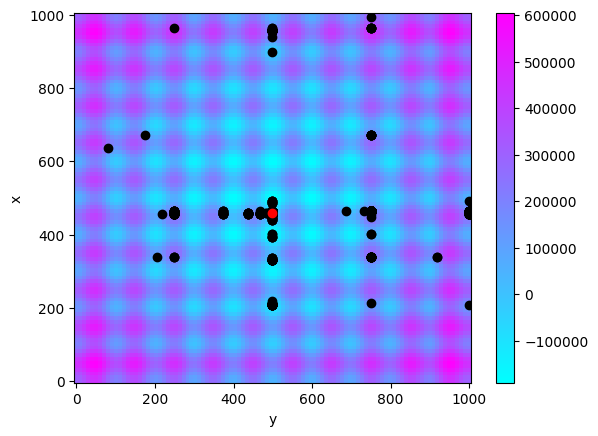

In [153]:
plt.pcolormesh(X, Y, Z, cmap = 'cool', shading='auto')
plt.xlabel('a')
plt.ylabel('b')
plt.colorbar()

df = pd.read_csv('ToyValues.csv')
plt.plot(df['a'],df['b'],'o', color='black')
plt.ylabel('x')
plt.xlabel('y')

#plot the best fitness
plt.plot(map_a,map_b,'o', color='red')

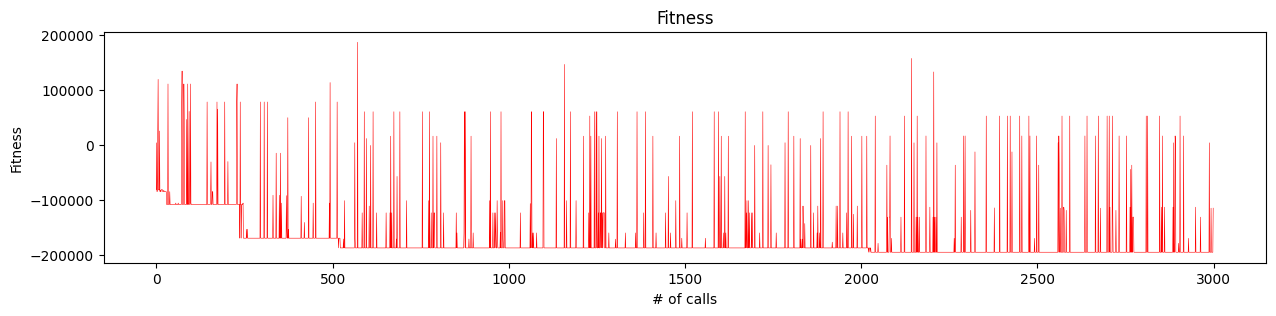

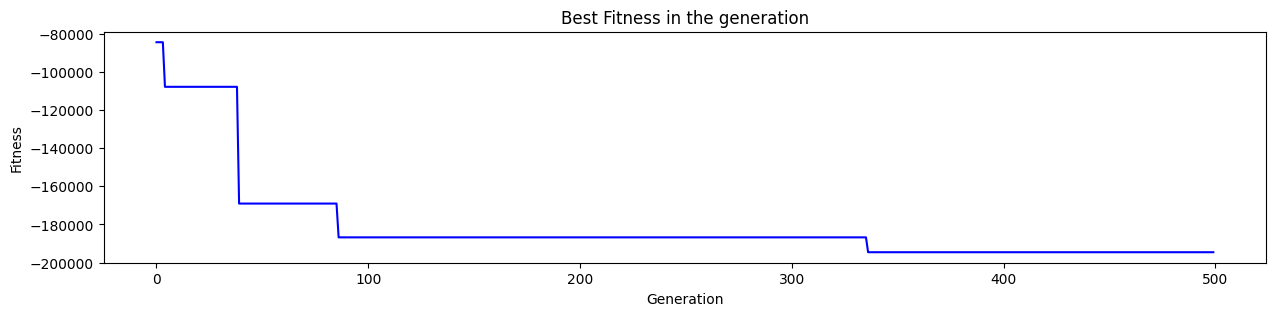

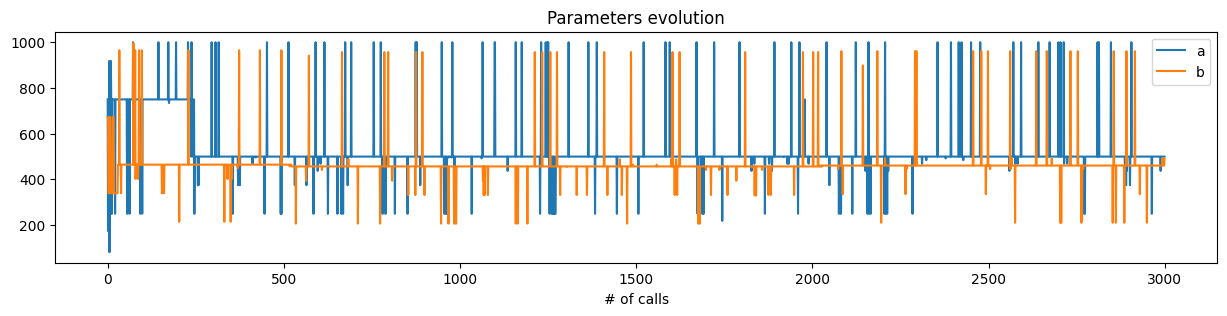

In [154]:
import pandas as pd
#read the values.csv
df = pd.read_csv('ToyValues.csv')

#adjust the figure size
plt.figure(figsize=(15,3))
#plot the fitness
pop_fit = []
best_generat = []
j = 0 
for i in range(len(df['fitness'])):
    j = j + 1
    pop_fit.append(df['fitness'][i])

    if j == population_size:
        best_generat.append(np.min(pop_fit))
        j = 0
        pop_fit = []


plt.plot(df['fitness'], 'r-', linewidth = 0.4)
plt.title('Fitness')
plt.xlabel('# of calls')
plt.ylabel('Fitness')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(best_generat, 'b-')
plt.title('Best Fitness in the generation')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()


plt.figure(figsize=(15,3))
plt.title('Parameters evolution')
plt.plot(df['a'], label='a')
plt.plot(df['b'], label='b')
plt.xlabel('# of calls')
plt.legend()
plt.show()
